In [1]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

from umap.umap_ import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS

code_id = "0860 - Decoding Retrieval With GNB"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

saved_dir = join(loc, "Decoded Results")
dir_name = join(figpath, "Dsp", "Reforming Neural Trajectory Analysis") 
mkdir(saved_dir)
pass

        E:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB is already existed!
        E:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results is already existed!


# Decoding with GNB Rather

In [2]:

def gnb_decoder(trace, n: int):
    """
    Decode the trace using the GNB decoder.
    """
    if exists(join(saved_dir, f" {int(trace['MiceID'])}_{n}.pkl")):
        with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"), 'rb') as f:
            (
                pos_traj,
                nodes_traj,
                speed_traj,
                smoothed_speed_traj,
                cumlen_traj,
                time_traj,
                lap_traj,
                route_traj,
                perfect_traj,
                raw_traj,
                
                loss_traj,
                smoothed_loss_traj,
                decoded_nodes_traj,
                decoded_nodes_traj_shuf,
                retriv_state_traj
            ) = pickle.load(f)
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(loss_traj)]))
    else:
        beg, end = LapSplit(trace, trace['paradigm'])
        beg_t, end_t = trace['lap beg time'], trace['lap end time']
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)
        
        raw_traces = trace['RawTraces']
        ms_time = trace['ms_time']
        spike_nodes = trace['spike_nodes_original']
        
        raw_traj = []
        pos_traj = []
        nodes_traj = []
        cumlen_traj = []
        time_traj = []
        lap_traj = []
        route_traj = []
        speed_traj = []
        perfect_traj = []
        
        print("Initialization.")
        for i in tqdm(range(len(beg))):
            spike_idx = np.where(
                (ms_time >= beg_t[i]) & (ms_time <= end_t[i]) &
                (np.isnan(trace['spike_nodes_original']) == False)
            )[0]
            ms_t = (ms_time[spike_idx]-ms_time[spike_idx[0]])/1000

            displacement = np.diff(trace['correct_pos'][beg[i]:end[i], :]/10, axis=0)
            dt = np.diff(trace['correct_time'][beg[i]:end[i]])
            speed = np.sqrt(np.sum(displacement**2, axis=1)) * 1000 / dt
            t = (trace['correct_time'][beg[i]:end[i]] - trace['correct_time'][beg[i]])/1000
            cumlen = np.cumsum(np.sqrt(np.sum(displacement**2, axis=1)))
            
            behav_to_ms_idx = _coordinate_recording_time(ms_t.astype(np.float64), t.astype(np.float64))

            pos_traj.append(trace['correct_pos'][beg[i]:end[i], :][behav_to_ms_idx, :].T/10)
            nodes_traj.append(trace['correct_nodes'][beg[i]:end[i]][behav_to_ms_idx])
            speed_traj.append(np.concatenate(([0], speed))[behav_to_ms_idx])
            cumlen_traj.append(np.concatenate(([0], cumlen))[behav_to_ms_idx])
            time_traj.append(ms_t)
            lap_traj.append(np.ones_like(ms_t) * i)
            route_traj.append(np.ones_like(ms_t) * routes[i])
            perfect_traj.append(np.ones_like(ms_t) * trace['is_perfect'][i])
            raw_traj.append(raw_traces[:, spike_idx])

        pos_traj = np.concatenate(pos_traj, axis=1).astype(np.float64)
        nodes_traj = np.concatenate(nodes_traj).astype(np.int64)
        speed_traj = np.concatenate(speed_traj).astype(np.float64)
        cumlen_traj = np.concatenate(cumlen_traj).astype(np.float64)
        time_traj = np.concatenate(time_traj).astype(np.float64)
        lap_traj = np.concatenate(lap_traj).astype(np.int64)

        route_traj = np.concatenate(route_traj).astype(np.int64)
        perfect_traj = np.concatenate(perfect_traj).astype(np.int64)
        raw_traj = np.concatenate(raw_traj, axis=1).astype(np.float64)
        Spikes = np.where(raw_traj - np.std(raw_traj, axis=1)[:, np.newaxis] * 3 >= 0, 1, 0)
        
        train_idx = np.where(route_traj == 0)[0]
        test_idx = np.setdiff1d(np.arange(nodes_traj.shape[0]), train_idx)
        
        D = GetDMatrices(1, 48)
        
        print("Decoding.")
        model = NaiveBayesDecoder(maze_type=1, res=48, smooth_matrix=trace['Ms'])
        model.fit(Spikes[:, train_idx], nodes_traj[train_idx])
        y_pred = model.predict(Spikes_test=Spikes, MazeID_test=nodes_traj)
        y_test = nodes_traj

        print("Decoding Shuffled Spikes.")
        loss_traj = D[(y_pred-1, y_test-1)]
        decoded_nodes_traj = y_pred
        p0 = np.where(Spikes == 0)[0].shape[0]
        Spike_train_shuf = cp.deepcopy(Spikes)
        for i in range(Spike_train_shuf.shape[0]):
            Spike_train_shuf[i, :] = np.random.permutation(Spike_train_shuf[i, :])
        y_pred_shuf = model.predict(Spikes_test=Spike_train_shuf, MazeID_test=nodes_traj)
        decoded_nodes_traj_shuf = y_pred_shuf
        
        smoothed_loss_traj = np.zeros_like(loss_traj, dtype=np.float64)
        smoothed_speed_traj = np.zeros_like(speed_traj, dtype=np.float64)
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(loss_traj)]))
        for i in range(len(beg)):
            smoothed_loss_traj[beg[i]:end[i]] = np.convolve(loss_traj[beg[i]:end[i]], np.ones(10)/10, mode='same')
            smoothed_speed_traj[beg[i]:end[i]] = np.convolve(speed_traj[beg[i]:end[i]], np.ones(3)/3, mode='same')
            
    print("Identify Retrieval Moment.")
    retriv_state_traj = np.zeros_like(loss_traj, dtype=np.int64)
    retriv_state_traj[smoothed_loss_traj < 10] = 1
    for i in range(len(beg)):
        if route_traj[beg[i]] == 0:
            retriv_state_traj[beg[i]:end[i]] = 1
            continue

        _converge_idx = np.where(smoothed_loss_traj[beg[i]:end[i]] <= 10)[0]

        if _converge_idx.shape[0] < 1:
            continue
        
        retriv_state_traj[beg[i]:beg[i] + _converge_idx[0]] = 0
        retriv_state_traj[beg[i] + _converge_idx[0]:end[i]] = 2
        retriv_state_traj[beg[i] + _converge_idx] = 1
    
    with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"), 'wb') as f:
        pickle.dump((
            pos_traj,
            nodes_traj,
            speed_traj,
            smoothed_speed_traj,
            cumlen_traj,
            time_traj,
            lap_traj,
            route_traj,
            perfect_traj,
            raw_traj,
            
            loss_traj,
            smoothed_loss_traj,
            decoded_nodes_traj,
            decoded_nodes_traj_shuf,
            retriv_state_traj
        ), f)
    
    return (
        pos_traj,
        nodes_traj,
        speed_traj,
        smoothed_speed_traj,
        cumlen_traj,
        time_traj,
        lap_traj,
        route_traj,
        perfect_traj,
        raw_traj,
        
        loss_traj,
        smoothed_loss_traj,
        decoded_nodes_traj,
        decoded_nodes_traj_shuf,
        retriv_state_traj
    )



# Example Laps

(248448,) (248448,)


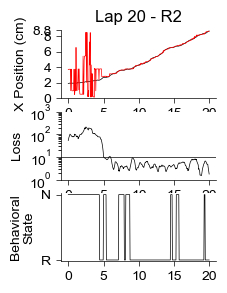

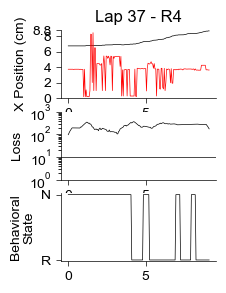

In [3]:
mouse = 10232
with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
    res = pickle.load(f)
    
pos_traj = res['raw_pos_traj']
nodes_traj = res['raw_nodes_traj']
speed_traj = res['raw_speed_traj']
cumlen_traj = res['raw_cumlen_traj']
time_traj = res['raw_time_traj']
lap_traj = res['raw_lap_traj']
route_traj = res['raw_route_traj']
perfect_traj = res['raw_perfect_traj']
raw_traj = res['raw_traj']
decoded_nodes_traj = res['raw_decoded_nodes_traj']
smoothed_loss_traj = res['raw_smoothed_loss_traj']
retriv_state_traj = res['raw_retriv_state_traj']
hidden_state_traj = res['raw_hidden_state_traj']
session_traj = res['raw_session_traj']
print(hidden_state_traj.shape, route_traj.shape)

D = GetDMatrices(1, 48)
pred_x = D[decoded_nodes_traj-1, 0] / np.max(D) * 111
test_x = D[nodes_traj-1, 0] / np.max(D) * 111

beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(lap_traj)]))

for i in range(len(beg)):
    if session_traj[beg[i]] != 0:
        continue
    
    if route_traj[beg[i]] == 0:
        continue
    
    if i not in [19, 36]:
        continue
    
    fig, axes = plt.subplots(3, 1, figsize=(2, 3))
    ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax0.plot(time_traj[beg[i]:end[i]], test_x[beg[i]:end[i]], color='black', lw=0.5)
    ax0.plot(time_traj[beg[i]:end[i]], pred_x[beg[i]:end[i]], color='red', lw=0.5)
    ax0.set_ylabel('X Position (cm)')
    ax0.set_title(f"Lap {i+1} - R{route_traj[beg[i]]+1}")
    ax0.set_ylim(0, 110)
    ax0.set_yticks([0, 25, 50, 75, 100, 110], (0, 2, 4, 6, 8, 8.8))
    xlim = ax0.get_xlim()
    ax0.set_xticks(np.linspace(0, 100, 21))
    ax0.set_xlim(xlim[0], xlim[1])
    
    ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax1.plot(time_traj[beg[i]:end[i]], smoothed_loss_traj[beg[i]:end[i]], color='black', lw=0.5)
    ax1.set_ylim(1, 1000)
    ax1.semilogy()
    ax1.axhline(10, color='k', lw=0.5)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Time (s)')
    ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
    ax1.set_xticks(np.linspace(0, 100, 21))
    ax1.set_xlim(xlim[0], xlim[1])
    
    ax2 = Clear_Axes(axes[2], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax2.plot(time_traj[beg[i]:end[i]], hidden_state_traj[beg[i]:end[i]], color='black', lw=0.5)
    ax2.set_ylim(-0.02, 1.02)
    ax2.set_yticks(np.linspace(0, 1, 2), ['R', 'N'])
    ax2.set_ylabel('Behavioral\nState')
    ax2.set_xticks(np.linspace(0, 100, 21))
    ax2.set_xlim(xlim[0], xlim[1])
    plt.savefig(join(loc, f"GNB Decoding Lap {i+1} - R{route_traj[beg[i]]+1}.png"), dpi=600)
    plt.savefig(join(loc, f"GNB Decoding Lap {i+1} - R{route_traj[beg[i]]+1}.svg"), dpi=600)
    plt.show()

# Behavioral Retrieval vs. Decoding Error

392


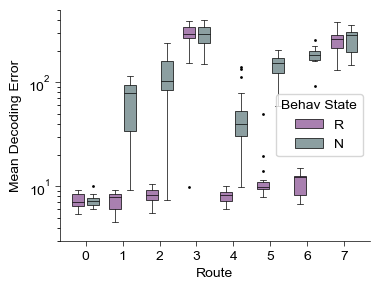

Route 0: TtestResult(statistic=0.34151924269081185, pvalue=0.7353564757483044, df=27)
Route 1: TtestResult(statistic=-9.382717981869586, pvalue=5.470472956529891e-10, df=27)
Route 2: TtestResult(statistic=-9.200115650025234, pvalue=8.230548022750478e-10, df=27)
Route 3: TtestResult(statistic=-0.13823197850161673, pvalue=0.8910828821359669, df=27)
Route 4: TtestResult(statistic=-6.287360028922171, pvalue=9.957590855723471e-07, df=27)
Route 5: TtestResult(statistic=-19.562839196485662, pvalue=1.7825598565159307e-17, df=27)
Route 6: TtestResult(statistic=-11.35815534672264, pvalue=3.2556856331712763e-06, df=8)
Route 7: TtestResult(statistic=-0.5529026426707764, pvalue=0.5871317675049279, df=18)


In [3]:

if exists(join(figdata, f" {code_id} [Behavioral Retriev vs. Decoding Error].pkl")) == False:
    BehavR_DecodErr = {
        "MiceID": [],
        "Session": [],
        "Route": [],
        "Mean Decoding Error": [],
        "Behav State": []
    }
    session_convertor = {
        10212: np.arange(-5, 2),
        10224: np.arange(7),
        10227: np.arange(-3, 4),
        10232: np.arange(-1, 6)
    }
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
            
        smoothed_loss_traj = res['raw_smoothed_loss_traj']
        hidden_state_traj = res['raw_hidden_state_traj']
        session_traj = res['raw_session_traj']
        route_traj = res['raw_route_traj']
        
        for s in range(7):
            for r in range(7):
                idx = np.where((session_traj == s)&(route_traj == r))[0]
            
                mean_loss_0 = np.nanmedian(smoothed_loss_traj[idx][hidden_state_traj[idx] == 0])
                mean_loss_1 = np.nanmedian(smoothed_loss_traj[idx][hidden_state_traj[idx] == 1])
        
                BehavR_DecodErr['MiceID'] += [mouse, mouse]
                BehavR_DecodErr['Session'] += [s, s]
                if session_convertor[mouse][s] >= 0 and r == 6:
                    BehavR_DecodErr['Route'] += [r+1, r+1]
                else:
                    BehavR_DecodErr['Route'] += [r, r]
                    
                BehavR_DecodErr['Mean Decoding Error'] += [mean_loss_0, mean_loss_1]
                BehavR_DecodErr['Behav State'] += ['R', 'N']
            
    for k in BehavR_DecodErr.keys():
        BehavR_DecodErr[k] = np.array(BehavR_DecodErr[k])
        
    with open(join(figdata, f"{code_id} [Behavioral Retriev vs. Decoding Error].pkl"), 'wb') as f:
        pickle.dump(BehavR_DecodErr, f)
        
    BehavR_DecodErr = pd.DataFrame(BehavR_DecodErr)
    BehavR_DecodErr.to_excel(join(figdata, f"{code_id} [Behavioral Retriev vs. Decoding Error].xlsx"), index=False)
    print(len(BehavR_DecodErr))
else:
    with open(join(figdata, f"{code_id} [Behavioral Retriev vs. Decoding Error].pkl"), 'rb') as f:
        BehavR_DecodErr = pickle.load(f)
    
fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
bbox = sns.boxplot(
    x='Route',
    y='Mean Decoding Error',
    data=BehavR_DecodErr,
    linecolor='black',
    linewidth=0.5,
    hue='Behav State',
    palette=BehavRetrievPalette,
    fliersize=1,
    gap=0.2,
    saturation=0.5,
)
for b in bbox.artists:
    b.set_linewidth(0)
    
ax.set_ylim(3, 500)
ax.semilogy()
ax.set_xlim(-0.7, 7.7)
plt.savefig(join(loc, "Behav Retrieval vs. Decoding Error.png"), dpi=600)
plt.savefig(join(loc, "Behav Retrieval vs. Decoding Error.svg"), dpi=600)
plt.show()

for r in range(8):
    idx0 = np.where((BehavR_DecodErr['Route'] == r)&(BehavR_DecodErr['Behav State'] == 'R'))[0]
    idx1 = np.where((BehavR_DecodErr['Route'] == r)&(BehavR_DecodErr['Behav State'] == 'N'))[0]
    print(f"Route {r}: {ttest_rel(BehavR_DecodErr['Mean Decoding Error'][idx0], BehavR_DecodErr['Mean Decoding Error'][idx1])}")

# Lap Duration (unit: Frame)

In [4]:
if exists(join(figdata, f"{code_id} [Lap Duration].pkl")) == False:
    LapDurationData = {
        'MiceID': [],
        'Session': [],
        'Lap Duration': [],
        'Route': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)

            route_traj = res['raw_route_traj']
            session_traj = res['raw_session_traj']
            lap_traj = res['raw_lap_traj']
        
            beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
            end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]))
            routes = route_traj[beg]
            
            LapDurationData['MiceID'].append(np.repeat(mouse, len(beg)))
            LapDurationData['Session'].append(session_traj[beg])
            LapDurationData['Lap Duration'].append(end - beg)
            LapDurationData['Route'].append(routes)
        
    for k in LapDurationData.keys():
        LapDurationData[k] = np.concatenate(LapDurationData[k])
        
    with open(join(figdata, f"{code_id} [Lap Duration].pkl"), 'wb') as f:
        pickle.dump(LapDurationData, f)
        
    LapDurationD = pd.DataFrame(LapDurationData)
    LapDurationD.to_excel(join(figdata, f"{code_id} [Lap Duration].xlsx"), index=False)
    print(len(LapDurationD))
else:
    with open(join(figdata, f"{code_id} [Lap Duration].pkl"), 'rb') as f:
        LapDurationData = pickle.load(f)
        
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.histplot(
    data=LapDurationData,
    x='Lap Duration',
    bins=np.arange(0, 1000, 20),
    stat='density',
    hue='Route',
    palette=DSPPalette,
    linewidth=0.5,
    edgecolor='black',
    element='step',
    alpha=0.5,
    ax=ax
)
ax.axvline(60, color='black', lw=0.5, ls='--')
ax.set_xlim(10, 1000)
ax.set_xticks(np.linspace(0, 1000, 11))
#ax.semilogx()

plt.savefig(join(loc, "Lap Duration Distribution.png"), dpi=600)
plt.savefig(join(loc, "Lap Duration Distribution.svg"))
plt.close()

# State Maintainence Interval

In [5]:
if exists(join(figdata, f"{code_id} [State Maintainence Interval].pkl")) == False:
    StateDurationData = {
        "MiceID": [],
        "Route": [],
        "State Duration": [],
        "State": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
            
        hidden_state_traj = res['raw_hidden_state_traj']
        route_traj = res['raw_route_traj']
        session_traj = res['raw_session_traj']
        
        beg = np.concatenate(([0], np.where(np.diff(hidden_state_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(hidden_state_traj) != 0)[0] + 1, [len(hidden_state_traj)]))
        routes = route_traj[beg]
        
        for i in range(len(beg)):
            hidden_state_cp = hidden_state_traj[beg[i]:end[i]]
            state_beg = np.concatenate(([0], np.where(np.diff(hidden_state_cp) != 0)[0] + 1))
            state_end = np.concatenate((np.where(np.diff(hidden_state_cp) != 0)[0] + 1, [len(hidden_state_cp)]))
            StateDurationData["MiceID"].append(np.repeat(mouse, len(state_beg)))
            StateDurationData["Route"].append(np.repeat(routes[i], len(state_beg)))
            StateDurationData["State Duration"].append(state_end - state_beg)
            StateDurationData["State"].append(hidden_state_cp[state_beg])
        
    for k in StateDurationData.keys():
        StateDurationData[k] = np.concatenate(StateDurationData[k])
        
    with open(join(figdata, f"{code_id} [State Maintainence Interval].pkl"), 'wb') as f:
        pickle.dump(StateDurationData, f)
        
    StateDurationD = pd.DataFrame(StateDurationData)
    StateDurationD.to_excel(join(figdata, f"{code_id} [State Maintainence Interval].xlsx"), index=False)
    print(len(StateDurationD))
else:
    with open(join(figdata, f"{code_id} [State Maintainence Interval].pkl"), 'rb') as f:
        StateDurationData = pickle.load(f)
        
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.histplot(
    data=StateDurationData,
    x='State Duration',
    bins=np.arange(0, 201, 5),
    stat='density',
    hue='State',
    palette=BehavRetrievPalette,
    linewidth=0.5,
    edgecolor='black',
    element='step',
    alpha=0.5,
    ax=ax
)
ax.set_xlim(-3, 203)
ax.set_xticks(np.linspace(0, 200, 5))
plt.savefig(join(loc, "State Duration Distribution.png"), dpi=600)
plt.savefig(join(loc, "State Duration Distribution.svg"), dpi=600)
plt.close()

# Predict Neuronal Retrieval From Behavioral Retrieval

In [19]:

def get_behav_retrieval_moment(
    hidden_state: np.ndarray, 
    min_t: int = 10
):
    hidden_state_cp = cp.deepcopy(hidden_state)
    state_switch = np.concatenate([[0], np.where(np.diff(hidden_state_cp) != 0)[0]+1, [len(hidden_state_cp)]])
    behav_state = hidden_state_cp[state_switch[:-1]]
    state_duration = state_switch[1:] - state_switch[:-1]
    i = np.where((behav_state == 0) & (state_duration >= min_t))[0]
    
    if i.shape[0] > 0:
        return state_switch[i[0]]
    else:
        return np.nan

if exists(join(figdata, f"{code_id} [Behav-based Prediction].pkl")) == False:
    BehavPredict = {
        'MiceID': [],
        'Session': [],
        'Route': [],
        'Duration': [],
        'Distance Loss': [],
        'Time Loss': [],
        'Type': [],
        'Time Real': [],
        'Time Pred': [],
        'Distance Real': [],
        'Distance Pred': []
    }
    BehavNeuralCorr = {
        "MiceID": [],
        "Route": [],
        "Duration": [],
        "Corr Time": [],
        "Corr Distance": [],
        'Session': [],
        'Session Corr Time':[],
        'Session Corr Distance': [],
        "Type": []
    }    
    
    init_bin = [CP_DSP[0][0:3], CP_DSP[1][0:3], CP_DSP[2][0:3], CP_DSP[3][0:3],
                CP_DSP[4][2:5], CP_DSP[5][3:6], CP_DSP[6][4:7]]
    D = GetDMatrices(1, 48)
    for dur in tqdm(range(1, 61)):
        for mouse in [10212, 10224, 10227, 10232]:
            n_abnormal = 0
            with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
                res = pickle.load(f)
            
            smoothed_loss_traj = res['raw_smoothed_loss_traj']
            hidden_state_traj = res['raw_hidden_state_traj']
            session_traj = res['raw_session_traj']
            route_traj = res['raw_route_traj']
            lap_traj = res['raw_lap_traj']
            nodes_traj = res['raw_nodes_traj']
            retriv_state_traj = res['raw_retriv_state_traj']
            time_traj = res['raw_time_traj']
            cumlen_traj = res['raw_cumlen_traj']
            perfect_traj = res['raw_perfect_traj']
            map_traj = res['raw_final_map_traj']
        
            beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
            end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]))
            routes = route_traj[beg]
            sessions = session_traj[beg]
            neural_retriev_moment = np.zeros_like(beg, np.float64)*np.nan
            behav_retriev_moment = np.zeros_like(beg, np.float64)*np.nan
            behav_retriev_moment_rand = np.zeros((beg.shape[0], 1000), np.float64)*np.nan
            
            start_idx = np.zeros(beg.shape[0], dtype=np.int64)
            for i in range(len(beg)):       
                start_bins = np.concatenate([
                    Father2SonGraph[n] for n in init_bin[routes[i]]
                ])
                idx = np.where(
                        np.isin(nodes_traj[beg[i]:end[i]], start_bins)
                )[0]
                
                if idx.shape[0] > 0:
                    start_idx[i] = beg[i] + idx[0]
                else:
                    start_idx[i] = beg[i]
                    n_abnormal += 1
                    print(f"Abnormal Start Index: {mouse} - {i+1} - {routes[i]+1}")
                
                behav_retriev_moment[i] = get_behav_retrieval_moment(
                    hidden_state_traj[beg[i]:end[i]], min_t=dur
                ) + beg[i]
                
                idx = np.where(retriv_state_traj[beg[i]:end[i]] == 1)[0]
                rt = route_traj[beg[i]]
                if idx.shape[0] > 0:
                    neural_retriev_moment[i] = beg[i] + idx[0]
                else:
                    neural_retriev_moment[i] = np.nan
                    
                behav_retriev_moment_rand[i, :] = np.random.randint(
                    beg[i], end[i], size=1000
                )

            loss = np.zeros_like(beg, dtype=np.float64) * np.nan
            time_loss = np.zeros_like(beg, dtype=np.float64) * np.nan
            unnan_idx = np.where(
                (neural_retriev_moment >= 0) &
                (behav_retriev_moment >= 0) &
                (route_traj[beg] != 3) &
                (route_traj[beg] != 0) &
                ((route_traj[beg] != 6) | (session_traj[beg] + min(session_convertor[mouse]) < 0))
            )[0]
            start_points = np.array([SP_DSP_RI[routes[i]] for i in unnan_idx]).astype(np.int64)
            loss[unnan_idx] = (
                D[(nodes_traj[neural_retriev_moment[unnan_idx].astype(np.int64)] - 1, start_points-1)] -
                D[(nodes_traj[behav_retriev_moment[unnan_idx].astype(np.int64)] - 1, start_points-1)]
            )**2
            time_loss[unnan_idx] = (
                time_traj[neural_retriev_moment[unnan_idx].astype(np.int64)] - 
                time_traj[behav_retriev_moment[unnan_idx].astype(np.int64)]
            )**2
            
            for rt in range(7):
                unnan_idx_rt = unnan_idx[np.where(routes[unnan_idx] == rt)[0]]
                BehavNeuralCorr['MiceID'].append(mouse)
                BehavNeuralCorr['Route'].append(rt)
                BehavNeuralCorr['Duration'].append(dur)
                
                BehavNeuralCorr['Corr Time'].append(
                    np.corrcoef(
                        time_traj[neural_retriev_moment[unnan_idx_rt].astype(np.int64)] - time_traj[start_idx[unnan_idx_rt]], 
                        time_traj[behav_retriev_moment[unnan_idx_rt].astype(np.int64)] - time_traj[start_idx[unnan_idx_rt]]
                    )[0, 1]
                )
                starting_points = np.array([SP_DSP_RI[routes[i]] for i in unnan_idx_rt]).astype(np.int64)
                BehavNeuralCorr['Corr Distance'].append(
                    np.corrcoef(
                        D[(nodes_traj[neural_retriev_moment[unnan_idx_rt].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx_rt]] - 1)], 
                        D[(nodes_traj[behav_retriev_moment[unnan_idx_rt].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx_rt]] - 1)]
                    )[0, 1]
                )
                BehavNeuralCorr['Type'].append('Predict')
                
            for s in range(7):
                unnan_idx_s = unnan_idx[np.where(sessions[unnan_idx] == s)[0]]
                BehavNeuralCorr['Session'].append(s)
                BehavNeuralCorr['Session Corr Time'].append(
                    np.corrcoef(
                        time_traj[neural_retriev_moment[unnan_idx_s].astype(np.int64)] - time_traj[start_idx[unnan_idx_s]], 
                        time_traj[behav_retriev_moment[unnan_idx_s].astype(np.int64)] - time_traj[start_idx[unnan_idx_s]]
                    )[0, 1]
                )
                starting_points = np.array([SP_DSP_RI[routes[i]] for i in unnan_idx_s]).astype(np.int64)
                BehavNeuralCorr['Session Corr Distance'].append(
                    np.corrcoef(
                        D[(nodes_traj[neural_retriev_moment[unnan_idx_s].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx_s]] - 1)], 
                        D[(nodes_traj[behav_retriev_moment[unnan_idx_s].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx_s]] - 1)]
                    )[0, 1]
                )
            
            loss_rand = np.zeros((beg.shape[0], 1000), dtype=np.float64) * np.nan
            time_loss_rand = np.zeros((beg.shape[0], 1000), dtype=np.float64) * np.nan
            for j in range(1000):
                start_points = np.array([SP_DSP_RI[routes[i]] for i in unnan_idx]).astype(np.int64)
                loss_rand[unnan_idx, j] = (
                    D[(nodes_traj[neural_retriev_moment[unnan_idx].astype(np.int64)] - 1, start_points-1)] -
                    D[(nodes_traj[behav_retriev_moment_rand[unnan_idx, j].astype(np.int64)] - 1, start_points-1)]
                )**2
                
                time_loss_rand[unnan_idx, j] = (
                    time_traj[neural_retriev_moment[unnan_idx].astype(np.int64)] -
                    time_traj[behav_retriev_moment_rand[unnan_idx, j].astype(np.int64)]
                )**2
                
                for rt in range(1, 7):
                    unnan_idx_rt = unnan_idx[np.where(routes[unnan_idx] == rt)[0]]
                    BehavNeuralCorr['MiceID'].append(mouse)
                    BehavNeuralCorr['Route'].append(rt)
                    BehavNeuralCorr['Duration'].append(dur)
                    BehavNeuralCorr['Corr Time'].append(
                        np.corrcoef(
                            time_traj[neural_retriev_moment[unnan_idx_rt].astype(np.int64)] - time_traj[start_idx[unnan_idx_rt]], 
                            time_traj[behav_retriev_moment_rand[unnan_idx_rt, j].astype(np.int64)] - time_traj[start_idx[unnan_idx_rt]]
                        )[0, 1]
                    )
                    starting_points = np.array([SP_DSP_RI[routes[i]] for i in unnan_idx_rt]).astype(np.int64)
                    BehavNeuralCorr['Corr Distance'].append(
                        np.corrcoef(
                            D[(nodes_traj[neural_retriev_moment[unnan_idx_rt].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx_rt]] - 1)], 
                            D[(nodes_traj[behav_retriev_moment_rand[unnan_idx_rt, j].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx_rt]] - 1)]
                        )[0, 1]
                    )
                    BehavNeuralCorr['Type'].append('Shuffle')
                    
                for s in range(7):
                    unnan_idx_s = unnan_idx[np.where(sessions[unnan_idx] == s)[0]]
                    BehavNeuralCorr['Session'].append(s)
                    BehavNeuralCorr['Session Corr Time'].append(
                        np.corrcoef(
                            time_traj[neural_retriev_moment[unnan_idx_s].astype(np.int64)] - time_traj[start_idx[unnan_idx_s]], 
                            time_traj[behav_retriev_moment_rand[unnan_idx_s, j].astype(np.int64)] - time_traj[start_idx[unnan_idx_s]]
                        )[0, 1]
                    )
                    starting_points = np.array([SP_DSP_RI[routes[i]] for i in unnan_idx_s]).astype(np.int64)
                    BehavNeuralCorr['Session Corr Distance'].append(
                        np.corrcoef(
                            D[(nodes_traj[neural_retriev_moment[unnan_idx_s].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx_s]] - 1)], 
                            D[(nodes_traj[behav_retriev_moment_rand[unnan_idx_s, j].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx_s]] - 1)]
                        )[0, 1]
                    )
                
            BehavPredict['MiceID'].append(np.repeat(mouse, len(beg[unnan_idx])*2))
            BehavPredict['Session'].append(np.concatenate([session_traj[beg[unnan_idx]]]*2))
            BehavPredict['Route'].append(np.concatenate([route_traj[beg[unnan_idx]]]*2))
            BehavPredict['Duration'].append(np.repeat(dur, len(beg[unnan_idx])*2))
            BehavPredict['Distance Loss'].append(np.concatenate([loss[unnan_idx], np.nanmean(loss_rand[unnan_idx, :], axis=1)]))
            BehavPredict['Time Loss'].append(np.concatenate([time_loss[unnan_idx], np.nanmean(time_loss_rand[unnan_idx, :], axis=1)]))
            BehavPredict['Type'].append(np.concatenate([
                np.repeat('Predict', len(beg[unnan_idx])), 
                np.repeat('Shuffle', len(beg[unnan_idx]))
            ]))
            BehavPredict['Time Real'].append(np.concatenate(
                [time_traj[neural_retriev_moment[unnan_idx].astype(np.int64)] - 
                 time_traj[start_idx[unnan_idx]]]+
                [time_traj[behav_retriev_moment_rand[unnan_idx, 0].astype(np.int64)] - time_traj[start_idx[unnan_idx]] for j in range(1)]
            ))
            BehavPredict['Time Pred'].append(np.concatenate(
                [time_traj[behav_retriev_moment[unnan_idx].astype(np.int64)] - time_traj[start_idx[unnan_idx]]]+
                [time_traj[behav_retriev_moment_rand[unnan_idx, 0].astype(np.int64)] - time_traj[start_idx[unnan_idx]] for j in range(1)]
            ))
            
            dist_real = D[(nodes_traj[neural_retriev_moment[unnan_idx].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx]] - 1)]
            dist_shuf = D[(nodes_traj[behav_retriev_moment_rand[unnan_idx, 0].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx]] - 1)]
            dist_behav = D[(nodes_traj[behav_retriev_moment[unnan_idx].astype(np.int64)] - 1, nodes_traj[start_idx[unnan_idx]] - 1)]
            BehavPredict['Distance Real'].append(np.concatenate(
                [dist_real, dist_shuf]
            ))
            BehavPredict['Distance Pred'].append(np.concatenate(
                [dist_behav, dist_shuf]
            ))
            
    for k in BehavPredict.keys():
        BehavPredict[k] = np.concatenate(BehavPredict[k])
    
    with open(join(figdata, f"{code_id} [Behav-based Prediction].pkl"), 'wb') as f:
        pickle.dump(BehavPredict, f)
    
    try:
        BehavPredictD = pd.DataFrame(BehavPredict)
        BehavPredictD.to_excel(join(figdata, f"{code_id} [Behav-based Prediction].xlsx"), index=False)
        print(len(BehavPredictD))
    except:
        print(len(BehavPredict['MiceID']))

    for k in BehavNeuralCorr.keys():
        BehavNeuralCorr[k] = np.array(BehavNeuralCorr[k])
    
    with open(join(figdata, f"{code_id} [Behav-based Prediction - Correlation].pkl"), 'wb') as f:
        pickle.dump(BehavNeuralCorr, f)
    
    try:
        BehavNeuralCorrD = pd.DataFrame(BehavNeuralCorr)
        BehavNeuralCorrD.to_excel(join(figdata, f"{code_id} [Behav-based Prediction - Correlation].xlsx"), index=False)
        print(len(BehavNeuralCorrD))
    except:
        print(len(BehavNeuralCorr['MiceID']))

else:
    with open(join(figdata, f"{code_id} [Behav-based Prediction].pkl"), 'rb') as f:
        BehavPredict = pickle.load(f)
        
    with open(join(figdata, f"{code_id} [Behav-based Prediction - Correlation].pkl"), 'rb') as f:
        BehavNeuralCorr = pickle.load(f)

    SubData = SubDict(
        BehavPredict, 
        BehavPredict.keys(), 
        np.where(
            (BehavPredict['Type'] == 'Predict') &
            (BehavPredict['Duration'] == 40) &
            np.isin(BehavPredict['Route'], [1, 2, 4, 5, 6])
        )[0]
    )
    SubD = pd.DataFrame(SubData)
    SubD.to_excel(join(figdata, f"{code_id} [Behav-based Prediction].xlsx"), index=False)
    
    SubCorr = SubDict(
        BehavNeuralCorr,
        BehavNeuralCorr.keys(),
        np.where(
            (BehavNeuralCorr['Type'] == 'Predict') &
            (BehavNeuralCorr['Duration'] == 40) &
            np.isin(BehavNeuralCorr['Route'], [1, 2, 4, 5, 6])
        )[0]
    )
    SubCorrD = pd.DataFrame(SubCorr)
    SubCorrD.to_excel(join(figdata, f"{code_id} [Behav-based Prediction - Correlation].xlsx"), index=False)

SubData = SubDict(
    BehavPredict, 
    BehavPredict.keys(), 
    np.where(
        (BehavPredict['Type'] == 'Predict') &
        (BehavPredict['Duration'] == 40) &
        np.isin(BehavPredict['Route'], [1, 2, 4, 5, 6])
    )[0]
)

def visualize_retrieval_moment(data: dict, y: str, file_name: str, ylim: tuple):
    fig = plt.figure(figsize=(1.8, 3))
    ax = Clear_Axes(
        plt.axes(), 
        close_spines=['top', 'right'], 
        ifxticks=True, 
        ifyticks=True
    )
    sns.stripplot(
        x='Route',
        y=y,
        hue='Route',
        order=[1, 2, 4, 5, 6],
        hue_order=[1, 2, 4, 5, 6],
        palette=[DSPPalette[rt] for rt in [1, 2, 4, 5, 6]],
        data=SubData,
        size=2, 
        linewidth=0.15,
        jitter=0.2,
        zorder=1,
        ax=ax,
        legend=False
    )
    sns.barplot(
        x='Route',
        y=y,
        order=[1, 2, 4, 5, 6],
        hue='Route',
        palette=[DSPPalette[rt] for rt in [1, 2, 4, 5, 6]],
        gap=0.2,
        data=SubData,
        ax=ax,
        zorder=2,
        capsize=0.3,
        err_kws={'color': 'black', 'linewidth': 0.5},
        legend=False
    )
    ax.set_ylim(*ylim)
    ax.set_xlim(-0.7, 4.7)
    plt.savefig(join(loc, f"{file_name}.png"), dpi=600)
    plt.savefig(join(loc, f"{file_name}.svg"), dpi=600)
    plt.show()

    print(f"Statistical Results for {y}:")
    res = [SubData[y][SubData['Route'] == i] for i in [1, 2, 4, 5, 6]]
    print_estimator(res[0])
    print_estimator(res[1])
    print_estimator(res[2])
    print_estimator(res[3])
    print_estimator(res[4])
    print(f_oneway(*res), end='\n\n')

"""
visualize_retrieval_moment(SubData, 'Time Real', "Decoding Retrieval Time", (0, 30))
visualize_retrieval_moment(SubData, 'Distance Real', "Decoding Retrieval Distance", (0, 200))
visualize_retrieval_moment(SubData, 'Time Pred', "Behavioral Retrieval Time", (0, 30))
visualize_retrieval_moment(SubData, 'Distance Pred', "Behavioral Retrieval Distance", (0, 250))


fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Duration',
    y='Corr Time',
    hue='Type',
    data=BehavNeuralCorr,
    palette=['#7b9bdc', 'k'],
    ax=ax,
    linewidth=0.5,
    legend=False,
    err_kws={'edgecolor':None},
)

ax.set_xticks(np.linspace(0, 60, 7))

plt.savefig(join(loc, "Correlation with Behavioral Retrieval Threshold [Time].png"), dpi=600)
plt.savefig(join(loc, "Correlation with Behavioral Retrieval Threshold [Time].svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Duration',
    y='Corr Distance',
    hue='Type',
    data=BehavNeuralCorr,
    palette=['#7b9bdc', 'k'],
    ax=ax,
    linewidth=0.5,
    legend=False,
    err_kws={'edgecolor':None},
)
ax.set_xticks(np.linspace(0, 60, 7))
ax.set_ylim(-0.1, 0.8)

plt.savefig(join(loc, "Correlation with Behavioral Retrieval Threshold [Distance].png"), dpi=600)
plt.savefig(join(loc, "Correlation with Behavioral Retrieval Threshold [Distance].svg"), dpi=600)
plt.show()


fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(
    SubData['Time Real'],
    SubData['Time Pred'],
    'o',
    markersize=2,
    markeredgewidth=0,
)
ax.set_aspect('equal')
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.plot([0, 30], [0, 30], c='k', lw=0.5)
ax.set_title(f"{np.corrcoef(SubData['Time Real'], SubData['Time Pred'])[0, 1]:.4f}")
plt.savefig(join(loc, "Retrieval Time Correlation.png"), dpi=600)
plt.savefig(join(loc, "Retrieval Time Correlation.svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(
    SubData['Distance Real'],
    SubData['Distance Pred'],
    'o',
    markersize=1,
    markeredgewidth=0,
)
ax.set_aspect('equal')
xlim = ax.get_xlim()
ax.set_xlim(0, xlim[1])
ax.set_ylim(0, xlim[1])
ax.plot([0, xlim[1]], [0, xlim[1]], c='k', lw=0.5)
ax.set_title(f"{np.corrcoef(SubData['Distance Real'], SubData['Distance Pred'])[0, 1]:.4f}")
plt.savefig(join(loc, "Retrieval Distance Correlation.png"), dpi=600)
plt.savefig(join(loc, "Retrieval Distance Correlation.svg"), dpi=600)
plt.show()

for rt in [1, 2, 4, 5, 6]:
    idx = np.where(SubData['Route'] == rt)[0]
    print(f"Route {rt}: {np.corrcoef(SubData['Time Real'][idx], SubData['Time Pred'][idx])[0, 1]:.4f}")
    print(f"Route {rt}: {np.corrcoef(SubData['Distance Real'][idx], SubData['Distance Pred'][idx])[0, 1]:.4f}")
""""""
BehavPredict['Distance Loss'] = -BehavPredict['Distance Loss']
BehavPredict['Time Loss'] = -BehavPredict['Time Loss']
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Duration',
    y='Time Loss',
    hue='Type',
    data=BehavPredict,
    palette=['#7b9bdc', 'k'],
    ax=ax,
    linewidth=0.5,
    legend=False,
    err_kws={'edgecolor': None},
)
ax.axhline(0, color='k', lw=0.5)
ax.axvline(21, color='k', lw=0.5)
ax.set_xticks(np.linspace(0, 60, 7))
plt.savefig(join(loc, "Time Loss With Duration.png"), dpi=600)
plt.savefig(join(loc, "Time Loss With Duration.svg"), dpi=600)
plt.show()
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Duration',
    y='Distance Loss',
    hue='Type',
    data=BehavPredict,
    palette=['#7b9bdc', 'k'],
    ax=ax,
    linewidth=0.5,
    legend=False,
    err_kws={'edgecolor': None},
)
ax.axhline(0, color='k', lw=0.5)
ax.axvline(32, color='k', lw=0.5)
ax.set_xticks(np.linspace(0, 60, 7))
plt.savefig(join(loc, "Distance Loss With Duration.png"), dpi=600)
plt.savefig(join(loc, "Distance Loss With Duration.svg"), dpi=600)
plt.show()

SubData = SubDict(
    BehavPredict, 
    BehavPredict.keys(), 
    np.where(
        (BehavPredict['Duration'] == 25) &
        np.isin(BehavPredict['Route'], [1, 2, 4, 5, 6])
    )[0]
)
fig, axes = plt.subplots(ncols=1, nrows=5, figsize=(3, 1.5*5), sharex=True)
for n, rt in enumerate([1, 2, 4, 5, 6]):
    SubData_rt = SubDict(
        SubData, 
        SubData.keys(), 
        np.where(SubData['Route'] == rt)[0]
    )
    ax0 = Clear_Axes(axes[n], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.histplot(
        data=SubData_rt,
        x='Distance Loss',
        bins=np.arange(-200, 301, 10),
        hue='Type',
        hue_order=['Predict', 'Shuffle'],
        palette=[DSPPalette[rt], 'k'],
        element='step',
        stat='density',
        ax=ax0,
        kde=True,
        line_kws={'linewidth': 0.5},
        legend=False
    )
    ax0.axvline(0, color='k', lw=0.5)
    ax0.set_xlim(-200, 300)
plt.savefig(join(loc, "Distance Loss Distribution.png"), dpi=600)
plt.savefig(join(loc, "Distance Loss Distribution.svg"))
plt.show()

fig, axes = plt.subplots(ncols=1, nrows=5, figsize=(3, 1.5*5), sharex=True)
for n, rt in enumerate([1, 2, 4, 5, 6]):
    SubData_rt = SubDict(
        SubData, 
        SubData.keys(), 
        np.where(SubData['Route'] == rt)[0]
    )
    ax1 = Clear_Axes(axes[n], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.histplot(
        data=SubData_rt,
        x='Time Loss',
        hue='Type',
        hue_order=['Predict', 'Shuffle'],
        palette=[DSPPalette[rt], 'k'],
        element='step',
        stat='density',
        ax=ax1,
        bins=np.arange(-10, 21, 1),
        line_kws={'linewidth': 0.5},
        kde=True,
        legend=False
    )
    ax1.axvline(0, color='k', lw=0.5)
    ax1.set_xlim(-10, 20)
plt.savefig(join(loc, "Time Loss Distribution.png"), dpi=600)
plt.savefig(join(loc, "Time Loss Distribution.svg"))
plt.show()
"""
pass

# Session Averaged Loss

In [1]:
SubData = SubDict(
    BehavPredict, 
    BehavPredict.keys(), 
    np.where(
        (BehavPredict['Duration'] == 25) &
        np.isin(BehavPredict['Route'], [1, 2, 4, 5, 6])
    )[0]
)

def hidden_state_proportion(
    mouse: int,
    rt: int = 0
):
    with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
        res = pickle.load(f)
        
    hidden_state_traj = res['raw_hidden_state_traj']
    session_traj = res['raw_session_traj']
    route_traj = res['raw_route_traj']
    nodes_traj = res['raw_nodes_traj']
    father_nodes_traj = S2F[nodes_traj-1]
    lap_traj = res['raw_lap_traj']
    time_traj = res['raw_time_traj']
    dt = np.zeros_like(time_traj, np.float64)
    
    beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
    end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]))
    for i in range(len(beg)):
        dt[beg[i]:end[i]] = np.diff(time_traj[beg[i]:end[i]], prepend=time_traj[beg[i]])
    
    if rt == 0:
        state_sum = np.zeros((144, 7*4))
        time_sum = np.zeros((144, 7*4))
        for s in range(7):
            n_lap = np.unique(lap_traj[(route_traj == 0) & (session_traj == s)])
            
            division = np.concatenate([np.arange(0, n_lap.shape[0], int(n_lap.shape[0]/4)+1), [n_lap.shape[0]]])
            for i in range(division.shape[0]-1):
                for b in CP_DSP[0]:
                    idx = np.where(
                        (np.isin(lap_traj, n_lap[division[i]:division[i+1]])) &
                        (session_traj == s) &
                        (route_traj == 0) & 
                        (father_nodes_traj == b)
                    )[0]
                    
                    if idx.shape[0] < 1:
                        continue                
                
                    state_sum[b-1, s*4 + i] = np.sum((1-hidden_state_traj[idx]) * dt[idx])
                    time_sum[b-1, s*4 + i] = np.sum(dt[idx])
        
        prop = np.zeros((144, 7*4))
        for j in range(prop.shape[1]):
            prop[CP_DSP[0]-1, j] = (
                np.convolve(state_sum[CP_DSP[0]-1, j], np.ones(7), mode='same') /
                np.convolve(time_sum[CP_DSP[0]-1, j], np.ones(7), mode='same')
            )
        
        return prop
    else:
        state_sum = np.zeros((144, 7))
        time_sum = np.zeros((144, 7))
        for s in range(7):
            for b in CP_DSP[rt]:
                idx = np.where(
                    (route_traj == rt) &
                    (session_traj == s) & 
                    (father_nodes_traj == b)
                )[0]
                
                if idx.shape[0] < 1:
                    continue
                
                state_sum[b-1, s] = np.sum((1-hidden_state_traj[idx]) * dt[idx])
                time_sum[b-1, s] = np.sum(dt[idx])
                
        prop = np.zeros((144, 7))
        for j in range(prop.shape[1]):
            prop[CP_DSP[rt]-1, j] = (
                np.convolve(state_sum[CP_DSP[rt]-1, j], np.ones(7), mode='same') /
                np.convolve(time_sum[CP_DSP[rt]-1, j], np.ones(7), mode='same')
            )
            
        if rt == 3:
            prop *= np.nan
        if rt == 6:
            convert_session = np.where(session_convertor[mouse] >= 0)[0][0]
            prop[:, convert_session:] = np.nan
        return prop


prop_r0 = hidden_state_proportion(10232, 0)
sem = scipy.stats.sem(prop_r0[CP_DSP[0]-1, :], axis=1)  # standard error of the mean
n = prop_r0.shape[1]

# 95% confidence interval (using t-distribution)
confidence = 0.95
h = sem * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
top_line = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1) + h
bottom_line = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1) - h

prop_r5 = hidden_state_proportion(10232, 5)

fig = plt.figure(figsize=(3, 1))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
for i in range(prop_r0.shape[1]):
    ax.plot(
        np.arange(1, 112),
        prop_r0[CP_DSP[0]-1, i],
        color='grey',
        lw=0.2
    )
ax.plot(
    np.arange(1, 112),
    np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1),
    color='k',
    lw=1
),
ax.fill_between(
    np.arange(1, 112),
    top_line,
    bottom_line,
    color='k',
    edgecolor=None,
    alpha=0.8
)
ax.plot(
    np.arange(1, 112)[-CP_DSP[5].shape[0]:],
    prop_r5[CP_DSP[5]-1, 0],
    color=DSPPalette[5],
    lw=1
)
ax.set_ylim(0, 1.02)
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(join(loc, "Hidden State Retrieval [Example].png"), dpi=600)
plt.savefig(join(loc, "Hidden State Retrieval [Example].svg"), dpi=600)
plt.show()

if exists(join(figdata, f" {code_id} [Session Averageed Loss].pkl")) == False:
    SessionAverageedLoss = {
        "MiceID": [],
        "Session": [],
        "Route": [],
        "Type": [],
        "Distance Loss": []
    }

    for mouse in [10212, 10224, 10227, 10232]:
        prop_r0 = hidden_state_proportion(mouse, 0)
        sem = scipy.stats.sem(prop_r0[CP_DSP[0]-1, :], axis=1)  # standard error of the mean
        n = prop_r0.shape[1]

        # 95% confidence interval (using t-distribution)
        confidence = 0.95
        h = sem * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
        top_line = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1) + h
        bottom_line = np.nanmean(prop_r0[CP_DSP[0]-1, :], axis=1) - h
        bottom_line_whole = np.zeros(144)
        bottom_line_whole[CP_DSP[0]-1] = bottom_line
        
        minus_bins = np.array([0, 0, 0, 0, 2, 3, 4])
        D = GetDMatrices(1, 12)
        
        dist_avg = np.nanmean(SubData['Distance Real'][SubData['MiceID'] == mouse])
        for r in [1, 2, 4, 5, 6]:
            prop_rt = hidden_state_proportion(mouse, r)
            for s in range(7):
                if r == 6 and session_convertor[mouse][s] >= 0:
                    continue
                
                SubData_r = SubDict(
                    SubData, 
                    SubData.keys(), 
                    np.where(
                        (SubData['MiceID'] == mouse) & 
                        (SubData['Route'] == r) &
                        (SubData['Session'] == s)
                    )[0]
                )
                idx0 = np.where(SubData_r['Type'] == 'Predict')[0]
                idx1 = np.where(SubData_r['Type'] == 'Shuffle')[0]
                
                mean_dist = np.nanmean((SubData_r['Distance Real'][idx0] - dist_avg)**2)
                mean_dist_shuf = np.nanmean(SubData_r['Distance Loss'][idx1])
                
                behav_retriev_bin = np.where(prop_rt[CP_DSP[r]-1, s] >= bottom_line_whole[CP_DSP[r]-1])[0]
                if behav_retriev_bin.shape[0] < 1:
                    behav_dist = np.nan
                else:
                    behav_dist = D[CP_DSP[r][behav_retriev_bin[0]] - 1, CP_DSP[r][minus_bins[r]] - 1]
                
                mean_behav_dist = np.nanmean((SubData_r['Distance Real'][idx0] - behav_dist)**2)
                
                SessionAverageedLoss['MiceID'].append(np.repeat(mouse, 3))
                SessionAverageedLoss['Route'].append(np.repeat(r, 3))
                SessionAverageedLoss['Session'].append(np.repeat(s, 3))
                SessionAverageedLoss['Type'].append(['Behavior', 'Distance', 'Shuffle'])
                SessionAverageedLoss['Distance Loss'].append([
                    np.sqrt(mean_behav_dist), 
                    np.sqrt(mean_dist), 
                    np.sqrt(mean_dist_shuf), 
                ])
    
    for k in SessionAverageedLoss.keys():
        SessionAverageedLoss[k] = np.concatenate(SessionAverageedLoss[k])
    
    """
    for mouse in [10212, 10224, 10227, 10232]:
        for r in [1, 2, 4, 5, 6]:
            idx = np.where(
                (SessionAverageedLoss['MiceID'] == mouse) & 
                (SessionAverageedLoss['Route'] == r)
            )[0]
            SessionAverageedLoss['Distance Loss'][idx] = (SessionAverageedLoss['Distance Loss'][idx] - np.nanmean(SessionAverageedLoss['Distance Loss'][idx])) / np.nanstd(SessionAverageedLoss['Distance Loss'][idx])
    """  
    with open(join(figdata, f"{code_id} [Session Averageed Loss].pkl"), 'wb') as f:
        pickle.dump(SessionAverageedLoss, f)
  
    SessionAverageedLossD = pd.DataFrame(SessionAverageedLoss)
    SessionAverageedLossD.to_excel(join(figdata, f"{code_id} [Session Averageed Loss].xlsx"), index=False)
    print(len(SessionAverageedLossD))
    
else:
    with open(join(figdata, f"{code_id} [Session Averageed Loss].pkl"), 'rb') as f:
        SessionAverageedLoss = pickle.load(f)

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Type',
    y='Distance Loss',
    hue='Type',
    data=SessionAverageedLoss,
    #marker='s',
    #markersize=5,
    #markeredgewidth=0.,
    palette=['#274753', '#299d8f', '#e7c66b'],
    ax=ax,
    size=4,
    linewidth=0.15,
    edgecolor='black',
    legend=False,
    jitter=0.2,
    zorder=1
)
sns.barplot(
    x='Type',
    y='Distance Loss',
    hue='Type',
    data=SessionAverageedLoss,
    #marker='s',
    #markersize=5,
    #markeredgewidth=0.,
    palette=['#274753', '#299d8f', '#e7c66b'],
    ax=ax,
    linewidth=0.5,
    legend=False,
    capsize=0.3,
    err_kws={'linewidth': 0.5, 'color': 'black'},
    gap=0.2,
    alpha=0.8,
    #err_kws={"edgecolor": None},
    #edgecolor='black',
)
ax.set_xlim(-0.6, 2.6)
ax.set_xticks(np.arange(0, 3, 1))
plt.savefig(join(loc, "RMSE Distance Loss.png"), dpi=600)
plt.savefig(join(loc, "RMSE Distance Loss.svg"), dpi=600)
plt.show()
idx1 = np.where((SessionAverageedLoss['Type'] == 'Behavior')&(np.isnan(SessionAverageedLoss['Distance Loss']) == False))[0]
idx2 = np.where((SessionAverageedLoss['Type'] == 'Distance')&(np.isnan(SessionAverageedLoss['Distance Loss']) == False))[0]
idx3 = np.where((SessionAverageedLoss['Type'] == 'Shuffle')&(np.isnan(SessionAverageedLoss['Distance Loss']) == False))[0]
print("RMSE Dist Loss: ")
print(f"  Behav vs. Dist: {ttest_rel(SessionAverageedLoss['Distance Loss'][idx1], SessionAverageedLoss['Distance Loss'][idx2])}")
print(f"                  {linregress(SessionAverageedLoss['Session'][idx1], SessionAverageedLoss['Distance Loss'][idx1])}")
print(f"  Behav vs. Shuf: {ttest_rel(SessionAverageedLoss['Distance Loss'][idx1], SessionAverageedLoss['Distance Loss'][idx3])}")
print(f"                  {linregress(SessionAverageedLoss['Session'][idx2], SessionAverageedLoss['Distance Loss'][idx2])}")
print(f"  Dist  vs. Shuf: {ttest_rel(SessionAverageedLoss['Distance Loss'][idx2], SessionAverageedLoss['Distance Loss'][idx3])}")
print(f"                  {linregress(SessionAverageedLoss['Session'][idx3], SessionAverageedLoss['Distance Loss'][idx3])}")

NameError: name 'SubDict' is not defined

# ROC Curve for Behavioral Prediction

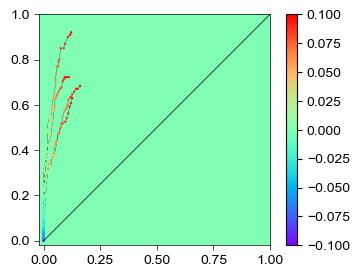

In [11]:
if exists(join(figdata, f"{code_id} [Unretrieved ROC].pkl")) == False:
    UnretrievedROC = {
        'MiceID': [],
        'Duration': [],
        'True Pos': [],
        'False Pos': [],
        'Line IDX': []
    }
    
    count = 0
    for mouse in [10212, 10224, 10227, 10232]:
        true_positive = np.zeros(60)
        false_positive = np.zeros(60)        
        for dur in tqdm(range(1, 61)):
        
            with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
                res = pickle.load(f)
            
            smoothed_loss_traj = res['raw_smoothed_loss_traj']
            hidden_state_traj = res['raw_hidden_state_traj']
            session_traj = res['raw_session_traj']
            route_traj = res['raw_route_traj']
            lap_traj = res['raw_lap_traj']
            nodes_traj = res['raw_nodes_traj']
            retriv_state_traj = res['raw_retriv_state_traj']
            time_traj = res['raw_time_traj']
            cumlen_traj = res['raw_cumlen_traj']
            perfect_traj = res['raw_perfect_traj']
            map_traj = res['raw_final_map_traj']
        
            beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
            end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]))
            routes = route_traj[beg]
            sessions = session_traj[beg]
            maps = map_traj[beg]
            
            neural_retriev_moment = np.zeros_like(beg, np.float64)*np.nan
            behav_retriev_moment = np.zeros_like(beg, np.float64)*np.nan
            behav_retriev_moment_rand = np.zeros((beg.shape[0], 1000), np.float64)*np.nan
        
            for i in range(len(beg)):            
                
                behav_retriev_moment[i] = get_behav_retrieval_moment(
                    hidden_state_traj[beg[i]:end[i]], min_t=dur
                ) + beg[i]
                
                idx = np.where(retriv_state_traj[beg[i]:end[i]] == 1)[0]
                rt = route_traj[beg[i]]
                if idx.shape[0] > 0:
                    neural_retriev_moment[i] = beg[i] + idx[0]
                else:
                    neural_retriev_moment[i] = np.nan
                    
                behav_retriev_moment_rand[i, :] = np.random.randint(
                    beg[i], end[i], size=1000
                )
                
            false_pos_idx = np.where(
                np.isnan(behav_retriev_moment) & 
                (maps == 0)
            )[0]
            true_pos_idx = np.where(
                np.isnan(behav_retriev_moment) &
                (maps == 1)
            )[0]
            if np.where((np.isnan(behav_retriev_moment)))[0].shape[0] > 0:
                false_positive[dur-1] = len(false_pos_idx) / len(np.where((maps == 0))[0])
                true_positive[dur-1] = len(true_pos_idx) / len(np.where((maps == 1))[0])
    

        UnretrievedROC['MiceID'].append(np.repeat(mouse, 60))
        UnretrievedROC['Duration'].append(np.arange(1, 61))
        UnretrievedROC['True Pos'].append(true_positive)
        UnretrievedROC['False Pos'].append(false_positive)
        UnretrievedROC['Line IDX'].append(np.repeat(count, 60))
        count += 1
                        
    for k in UnretrievedROC.keys():
        UnretrievedROC[k] = np.concatenate(UnretrievedROC[k])
        
    with open(join(figdata, f"{code_id} [Unretrieved ROC].pkl"), 'wb') as f:
        pickle.dump(UnretrievedROC, f)
        
    UnretrievedROCD = pd.DataFrame(UnretrievedROC)
    UnretrievedROCD.to_excel(join(figdata, f"{code_id} [Unretrieved ROC].xlsx"), index=False)
    print(len(UnretrievedROCD))
else:
    with open(join(figdata, f"{code_id} [Unretrieved ROC].pkl"), 'rb') as f:
        UnretrievedROC = pickle.load(f)

fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=[], ifxticks=True, ifyticks=True)
beg = np.concatenate(([0], np.where(np.diff(UnretrievedROC['Line IDX']) != 0)[0] + 1))
end = np.concatenate((np.where(np.diff(UnretrievedROC['Line IDX']) != 0)[0] + 1, [len(UnretrievedROC['Line IDX'])]))
session_colors = sns.color_palette("rainbow", 7)
dur_colors = sns.color_palette("coolwarm", 60)
for i in range(len(beg)):
    ax.plot(
        UnretrievedROC['False Pos'][beg[i]:end[i]], 
        UnretrievedROC['True Pos'][beg[i]:end[i]], 
        color='k',
        lw=0.2,
        zorder=1
    )
ax.scatter(
    UnretrievedROC['False Pos'], 
    UnretrievedROC['True Pos'], 
    s=0.5,
    c=UnretrievedROC['Duration']-1,
    cmap=sns.color_palette("rainbow", as_cmap=True),
    edgecolors=None,
    zorder=2
)
im = ax.imshow(np.zeros((4, 4)), cmap=sns.color_palette("rainbow", as_cmap=True))
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
ax.plot([0, 1], [0, 1], color='black', lw=0.5)
ax.axis([-0.02, 1, -0.02, 1])
ax.set_aspect('equal')
plt.savefig(join(loc, "Unretrieved ROC.png"), dpi=600)
plt.savefig(join(loc, "Unretrieved ROC.svg"), dpi=600)
plt.show()

# Time and Position Prediction

363


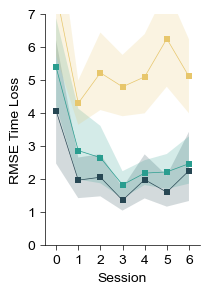

RMSE Time Loss: 
  Behav vs. Time: TtestResult(statistic=-2.7907510822684114, pvalue=0.0061195080830399335, df=120)
                  LinregressResult(slope=-0.23878694937046496, intercept=2.8953169133718464, rvalue=-0.20756351986713556, pvalue=0.022345813739656415, stderr=0.10316284301004226, intercept_stderr=0.36213411420585434)
  Behav vs. Shuf: TtestResult(statistic=-11.574949294980888, pvalue=2.8850404948496386e-21, df=120)
                  LinregressResult(slope=-0.39628042419696063, intercept=3.9817213530713778, rvalue=-0.3595763540382872, pvalue=5.108180387661381e-05, stderr=0.09426999730773569, intercept_stderr=0.3309174211872193)
  Time vs. Shuf: TtestResult(statistic=-11.119795704096537, pvalue=3.550147069905636e-20, df=120)
                  LinregressResult(slope=-0.15699000690947745, intercept=5.952916453761455, rvalue=-0.10446377659187592, pvalue=0.2541626542782374, stderr=0.13700932364593818, intercept_stderr=0.4809459356566516)


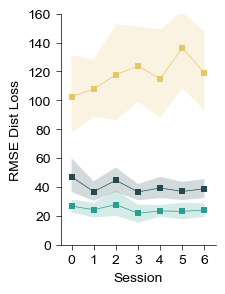

RMSE Dist Loss: 
  Behav vs. Dist: TtestResult(statistic=9.678759866416133, pvalue=1.0029872860036204e-16, df=120)
                  LinregressResult(slope=-1.1046800662743048, intercept=43.34849201918285, rvalue=-0.12613656869643264, pvalue=0.16801411439947864, stderr=0.7964148284064257, intercept_stderr=2.795667219032473)
  Behav vs. Shuf: TtestResult(statistic=-13.486425163895218, pvalue=8.504473236958686e-26, df=120)
                  LinregressResult(slope=-0.5483721817228259, intercept=26.107263295298043, rvalue=-0.08685883606422885, pvalue=0.34347496351342677, stderr=0.5765586074299651, intercept_stderr=2.023902545697454)
  Dist  vs. Shuf: TtestResult(statistic=-16.246256211416178, pvalue=4.327485958111381e-32, df=120)
                  LinregressResult(slope=3.7441830544754953, intercept=106.15882687006024, rvalue=0.12542551820236866, pvalue=0.17044374566235695, stderr=2.7149039445680296, intercept_stderr=9.530169065081104)


In [12]:
SubData_t = SubDict(
    BehavPredict, 
    BehavPredict.keys(), 
    np.where(
        (BehavPredict['Duration'] == 21) &
        np.isin(BehavPredict['Route'], [1, 2, 4, 5, 6])
    )[0]
)
SubData_d = SubDict(
    BehavPredict, 
    BehavPredict.keys(), 
    np.where(
        (BehavPredict['Duration'] == 33) &
        np.isin(BehavPredict['Route'], [1, 2, 4, 5, 6])
    )[0]
)
    
if exists(join(figdata, f" {code_id} [Time, Position, and time].pkl")) == False:
    RMSEData = {
        'MiceID': [],
        'Route': [],
        'Session': [],
        'RMSE Time Loss': [],
        'RMSE Dist Loss': [],
        'Parameter': [],
    }
    time_thre = np.nanmean(SubData_t['Time Real'][SubData_t['Type'] == 'Predict'])
    dist_thre = np.nanmean(SubData_d['Distance Real'][SubData_d['Type'] == 'Predict'])    
    for mouse in [10212, 10224, 10227, 10232]:

        for r in [1, 2, 4, 5, 6]:
            for s in range(7):
                SubData_t_r = SubDict(
                    SubData_t, 
                    SubData_t.keys(), 
                    np.where((SubData_t['MiceID'] == mouse) & (SubData_t['Route'] == r) & (SubData_t['Session'] == s))[0]
                )
                idx0 = np.where(SubData_t_r['Type'] == 'Predict')[0]
                idx1 = np.where(SubData_t_r['Type'] == 'Shuffle')[0]
                if idx0.shape[0] == 0 or idx1.shape[0] == 0:
                    continue
                time_loss_behav = np.nanmean(np.abs(SubData_t_r['Time Pred'][idx0] - SubData_t_r['Time Real'][idx0]))
                time_loss_shuf = np.nanmean(np.abs(SubData_t_r['Time Real'][idx1] - SubData_t_r['Time Real'][idx0]))
                time_loss_time = np.nanmean(np.abs(time_thre - SubData_t_r['Time Real'][idx0]))
                
                SubData_d_r = SubDict(
                    SubData_d, 
                    SubData_d.keys(), 
                    np.where((SubData_d['MiceID'] == mouse) & (SubData_d['Route'] == r) & (SubData_d['Session'] == s))[0]
                )
                idx0 = np.where(SubData_d_r['Type'] == 'Predict')[0]
                idx1 = np.where(SubData_d_r['Type'] == 'Shuffle')[0]
                dist_loss_behav = np.nanmean(np.abs(SubData_d_r['Distance Pred'][idx0] - SubData_d_r['Distance Real'][idx0]))
                dist_loss_shuf = np.nanmean(np.abs(SubData_d_r['Distance Real'][idx1] - SubData_d_r['Distance Real'][idx0]))
                dist_loss_dist = np.nanmean(np.abs(dist_thre - SubData_d_r['Distance Real'][idx0]))
                RMSEData['MiceID'].append(np.repeat(mouse, 3))
                RMSEData['Route'].append(np.repeat(r, 3))
                RMSEData['RMSE Time Loss'].append([
                    time_loss_behav, 
                    time_loss_time,
                    time_loss_shuf
                ])
                RMSEData['RMSE Dist Loss'].append([
                    dist_loss_behav, 
                    dist_loss_dist,
                    dist_loss_shuf
                ])
                RMSEData['Parameter'].append(['Behavior', 'Param', 'Shuffle'])
                RMSEData['Session'].append(np.repeat(s, 3))
        
    for k in RMSEData.keys():
        RMSEData[k] = np.concatenate(RMSEData[k])
            
    with open(join(figdata, f"{code_id} [Time, Position, and time].pkl"), 'wb') as f:
        pickle.dump(RMSEData, f)
        
    RMSED = pd.DataFrame(RMSEData)
    RMSED.to_excel(join(figdata, f"{code_id} [Time, Position, and time].xlsx"), index=False)
    print(len(RMSED))
else:
    with open(join(figdata, f"{code_id} [Time, Position, and time].pkl"), 'rb') as f:
        RMSEData = pickle.load(f)


fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Session',
    y='RMSE Time Loss',
    hue='Parameter',
    data=RMSEData,
    palette=['#274753', '#299d8f', '#e7c66b'],
    ax=ax,
    linewidth=0.5,
    legend=False,
    err_kws={'edgecolor': None},
    marker='s',
    markersize=5,
    markeredgewidth=0
)
ax.set_ylim(0, 7)
ax.set_xlim(-0.5, 6.5)
ax.set_xticks(np.arange(0, 7, 1))
plt.savefig(join(loc, "RMSE Time Loss.png"), dpi=600)
plt.savefig(join(loc, "RMSE Time Loss.svg"), dpi=600)
plt.show()
idx1 = np.where((RMSEData['Parameter'] == 'Behavior')&(np.isnan(RMSEData['RMSE Time Loss']) == False))[0]
idx2 = np.where((RMSEData['Parameter'] == 'Param')&(np.isnan(RMSEData['RMSE Time Loss']) == False))[0]
idx3 = np.where((RMSEData['Parameter'] == 'Shuffle')&(np.isnan(RMSEData['RMSE Time Loss']) == False))[0]
print("RMSE Time Loss: ")
print(f"  Behav vs. Time: {ttest_rel(RMSEData['RMSE Time Loss'][idx1], RMSEData['RMSE Time Loss'][idx2])}")
print(f"                  {linregress(RMSEData['Session'][idx3], RMSEData['RMSE Time Loss'][idx1])}")
print(f"  Behav vs. Shuf: {ttest_rel(RMSEData['RMSE Time Loss'][idx1], RMSEData['RMSE Time Loss'][idx3])}")
print(f"                  {linregress(RMSEData['Session'][idx3], RMSEData['RMSE Time Loss'][idx2])}")
print(f"  Time vs. Shuf: {ttest_rel(RMSEData['RMSE Time Loss'][idx2], RMSEData['RMSE Time Loss'][idx3])}")
print(f"                  {linregress(RMSEData['Session'][idx3], RMSEData['RMSE Time Loss'][idx3])}")

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Session',
    y='RMSE Dist Loss',
    hue='Parameter',
    data=RMSEData,
    marker='s',
    markersize=5,
    markeredgewidth=0,
    palette=['#274753', '#299d8f', '#e7c66b'],
    ax=ax,
    linewidth=0.5,
    legend=False,
    err_kws={'edgecolor': None}
)
ax.set_xlim(-0.5, 6.5)
ax.set_xticks(np.arange(0, 7, 1))
ax.set_ylim(0, 160)
plt.savefig(join(loc, "RMSE Distance Loss.png"), dpi=600)
plt.savefig(join(loc, "RMSE Distance Loss.svg"), dpi=600)
plt.show()
idx1 = np.where((RMSEData['Parameter'] == 'Behavior')&(np.isnan(RMSEData['RMSE Dist Loss']) == False))[0]
idx2 = np.where((RMSEData['Parameter'] == 'Param')&(np.isnan(RMSEData['RMSE Dist Loss']) == False))[0]
idx3 = np.where((RMSEData['Parameter'] == 'Shuffle')&(np.isnan(RMSEData['RMSE Dist Loss']) == False))[0]
print("RMSE Dist Loss: ")
print(f"  Behav vs. Dist: {ttest_rel(RMSEData['RMSE Dist Loss'][idx1], RMSEData['RMSE Dist Loss'][idx2])}")
print(f"                  {linregress(RMSEData['Session'][idx1], RMSEData['RMSE Dist Loss'][idx1])}")
print(f"  Behav vs. Shuf: {ttest_rel(RMSEData['RMSE Dist Loss'][idx1], RMSEData['RMSE Dist Loss'][idx3])}")
print(f"                  {linregress(RMSEData['Session'][idx2], RMSEData['RMSE Dist Loss'][idx2])}")
print(f"  Dist  vs. Shuf: {ttest_rel(RMSEData['RMSE Dist Loss'][idx2], RMSEData['RMSE Dist Loss'][idx3])}")
print(f"                  {linregress(RMSEData['Session'][idx3], RMSEData['RMSE Dist Loss'][idx3])}")

# Learning Effect

1.4742754518668554e-18


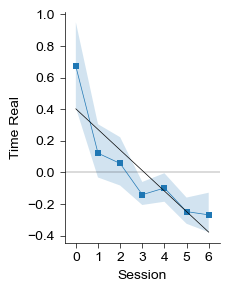

7.476401294421818e-06


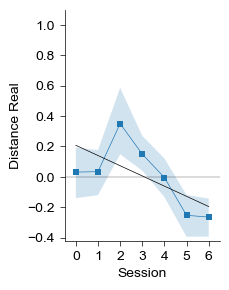

In [14]:
SubData = SubDict(
    BehavPredict, 
    BehavPredict.keys(), 
    np.where(
        (BehavPredict['Type'] == 'Predict') &
        (BehavPredict['Duration'] == 22) &
        np.isin(BehavPredict['Route'], [1, 2, 4, 5, 6])
    )[0]
)

for r in [1, 2, 4, 5, 6]:
    idx = np.where(SubData['Route'] == r)[0]
    SubData['Time Real'][idx] = (SubData['Time Real'][idx] - np.nanmean(SubData['Time Real'][idx])) / np.nanstd(SubData['Time Real'][idx])
    SubData['Distance Real'][idx] = (SubData['Distance Real'][idx] - np.nanmean(SubData['Distance Real'][idx])) / np.nanstd(SubData['Distance Real'][idx])

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', lw=0.2)
sns.lineplot(
    x='Session',
    y='Time Real',
    data=SubData,
    ax=ax,
    linewidth=0.5,
    legend=False,
    err_kws={'edgecolor': None},
    marker='s',
    markersize=5,
    markeredgewidth=0
)
ax.set_xlim(-0.5, 6.5)
ax.set_xticks(np.arange(0, 7, 1))
lr = linregress(SubData['Session'], SubData['Time Real'])
x = np.linspace(0, 6, 2)
ax.plot(x, lr.intercept + lr.slope * x, c='k', lw=0.5)
print(lr.pvalue)
plt.savefig(join(loc, "Learning Effect (Time).png"), dpi=600)
plt.savefig(join(loc, "Learning Effect (Time).svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', lw=0.2)
sns.lineplot(
    x='Session',
    y='Distance Real',
    data=SubData,
    ax=ax,
    linewidth=0.5,
    legend=False,
    err_kws={'edgecolor': None},
    marker='s',
    markersize=5,
    markeredgewidth=0
)
ax.set_xlim(-0.5, 6.5)
ax.set_xticks(np.arange(0, 7, 1))
lr = linregress(SubData['Session'], SubData['Distance Real'])
x = np.linspace(0, 6, 2)
ax.set_ylim(-0.42, 1.1)
ax.plot(x, lr.intercept + lr.slope * x, c='k', lw=0.5)
print(lr.pvalue)
plt.savefig(join(loc, "Learning Effect (Distance).png"), dpi=600)
plt.savefig(join(loc, "Learning Effect (Distance).svg"), dpi=600)
plt.show()